In [7]:
#INSTALL LIBRARIES
!pip install yfinance pandas numpy scikit-learn xgboost shap lime matplotlib seaborn tensorflow


In [8]:
#IMPORT LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import shap
from lime.lime_tabular import LimeTabularExplainer

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras


In [9]:
# Download 10 years of Apple stock prices
data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")

# Save dataset
data.to_csv("apple_stock.csv")

print("Dataset downloaded successfully!")
data.head()


/tmp/ipython-input-3270469358.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Dataset downloaded successfully!


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.156706,17.277674,17.122277,17.235801,234684800
2014-01-03,16.779840,17.174382,16.762780,17.148328,392467600
2014-01-06,16.871347,16.960367,16.550936,16.670354,412610800
2014-01-07,16.750690,16.934313,16.684934,16.883445,317209200
2014-01-08,16.856764,16.921900,16.708811,16.712531,258529600


In [10]:
#FEATURE ENGINEERING
df = data.copy()

# Percentage returns
df["Return_1d"] = df["Close"].pct_change()
df["Return_5d"] = df["Close"].pct_change(5)

# Volatility
df["Volatility_5d"] = df["Return_1d"].rolling(5).std()

# Lag Features
df["Lag1"] = df["Return_1d"].shift(1)
df["Lag5"] = df["Return_1d"].shift(5)

# Target: Will price increase after 5 days?
df["Target"] = (df["Close"].shift(-5) > df["Close"]).astype(int)

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume,Return_1d,Return_5d,Volatility_5d,Lag1,Lag5,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2014-01-10,16.530457,16.774254,16.473694,16.744166,304976000,-0.006673,-0.014862,0.008437,-0.012770,-0.021966,1
2014-01-13,16.616997,16.826985,16.435544,16.436475,378492800,0.005235,-0.015076,0.008383,-0.006673,0.005453,1
2014-01-14,16.947651,16.958196,16.676867,16.694238,332561600,0.019899,0.011758,0.012670,0.005235,-0.007152,1
2014-01-15,17.287909,17.375999,17.111109,17.168802,391638800,0.020077,0.025577,0.015010,0.019899,0.006332,0
2014-01-16,17.191444,17.272090,17.111728,17.211606,229278000,-0.005580,0.033046,0.013085,0.020077,-0.012770,0


In [11]:
#TRAIN–TEST SPLIT
features = ["Return_1d", "Return_5d", "Volatility_5d", "Lag1", "Lag5"]
X = df[features]
y = df["Target"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape


((2008, 5), (502, 5))

In [12]:
#SCALE DATA (Needed for Neural Network)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
#MODEL 1: XGBOOST TRAINING
model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
#XGBOOST PREDICTIONS + METRICS
preds = model_xgb.predict(X_test)
probs = model_xgb.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)
recall = recall_score(y_test, preds)

print("Accuracy:", accuracy)
print("AUC:", auc)
print("Recall:", recall)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))


Accuracy: 0.5239043824701195
AUC: 0.5013994910941476
Recall: 0.767175572519084

Confusion Matrix:
 [[ 62 178]
 [ 61 201]]


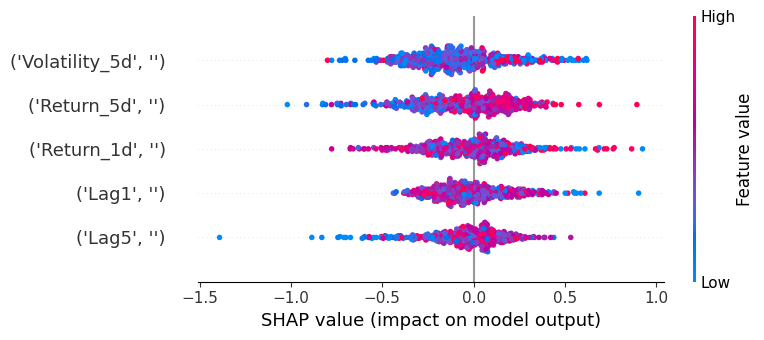

In [15]:
#SHAP (GLOBAL SUMMARY)
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary.png", dpi=300)
plt.show()


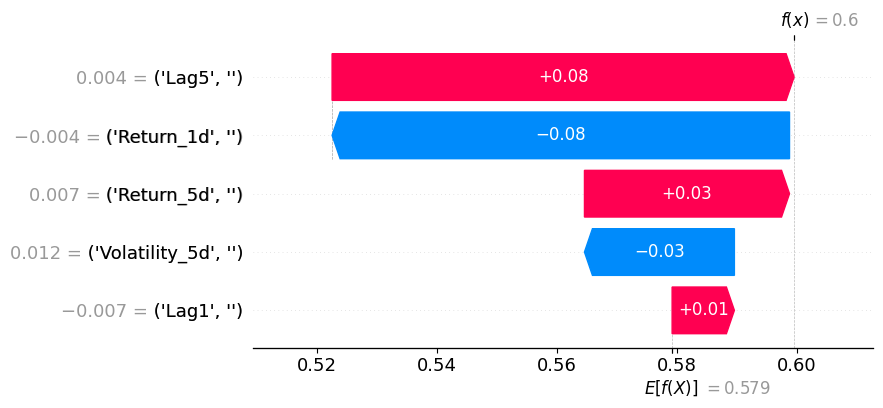

<Figure size 640x480 with 0 Axes>

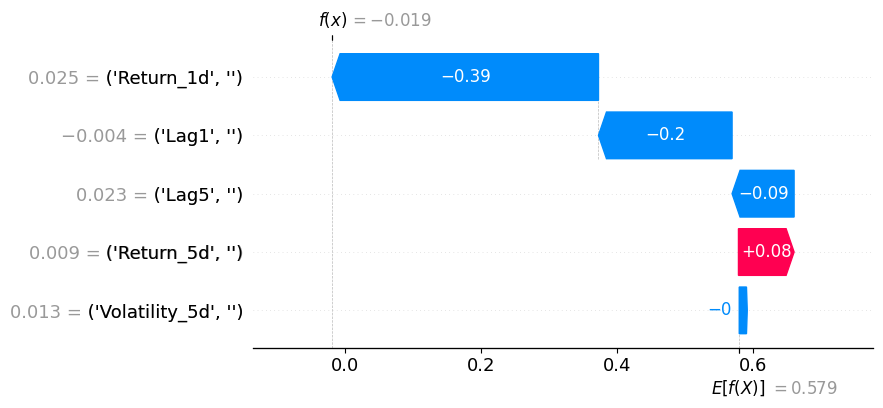

<Figure size 640x480 with 0 Axes>

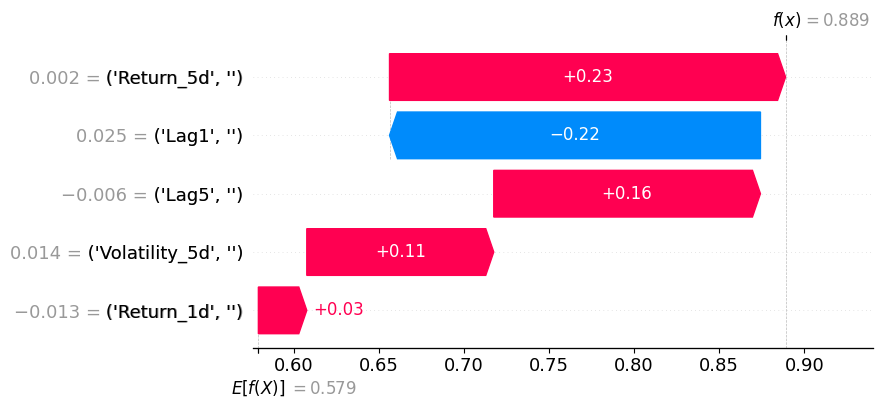

<Figure size 640x480 with 0 Axes>

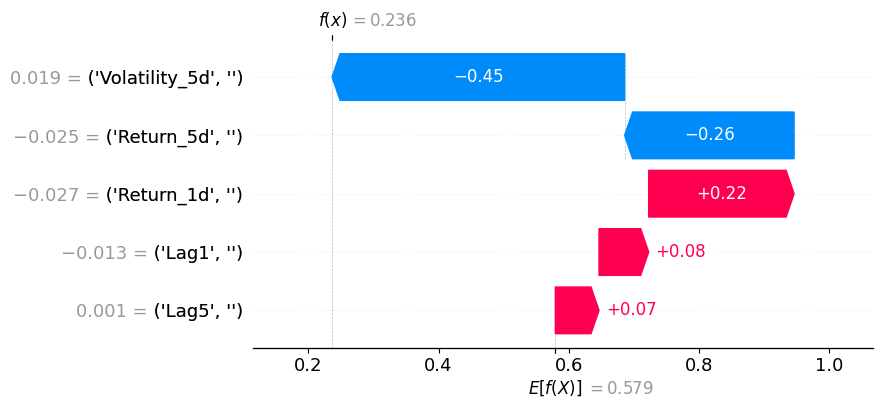

<Figure size 640x480 with 0 Axes>

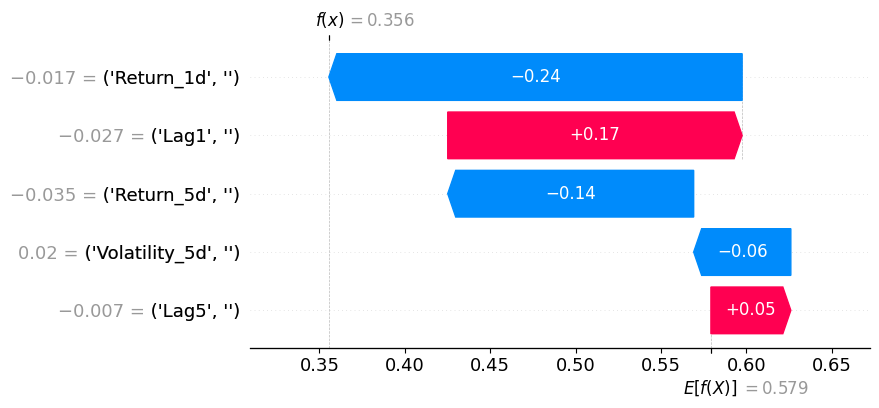

<Figure size 640x480 with 0 Axes>

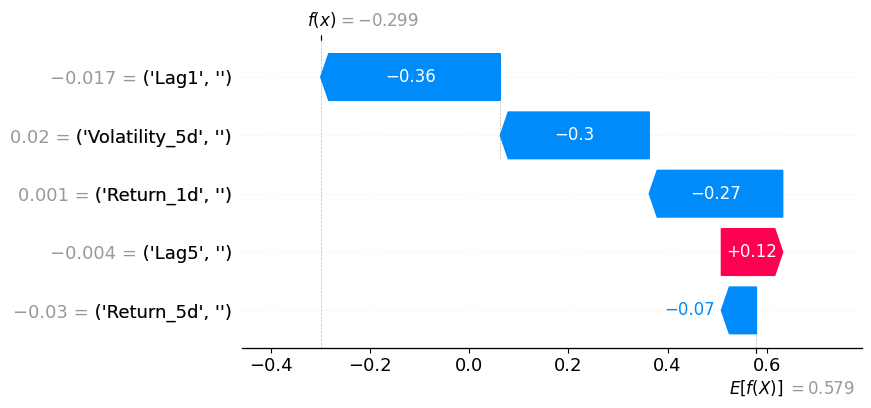

<Figure size 640x480 with 0 Axes>

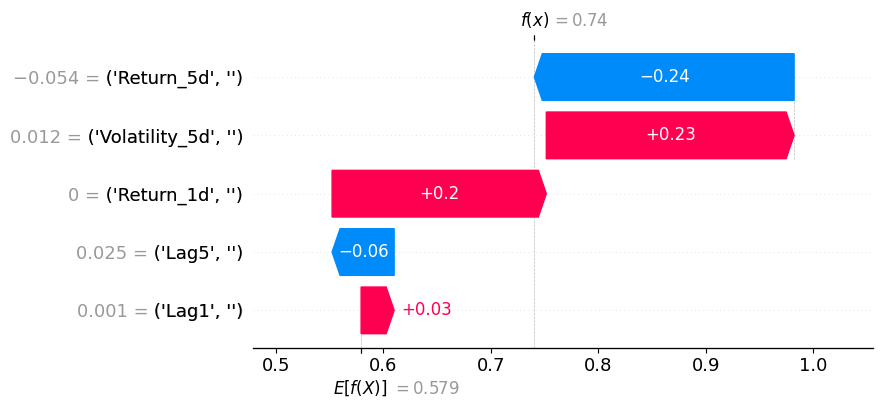

<Figure size 640x480 with 0 Axes>

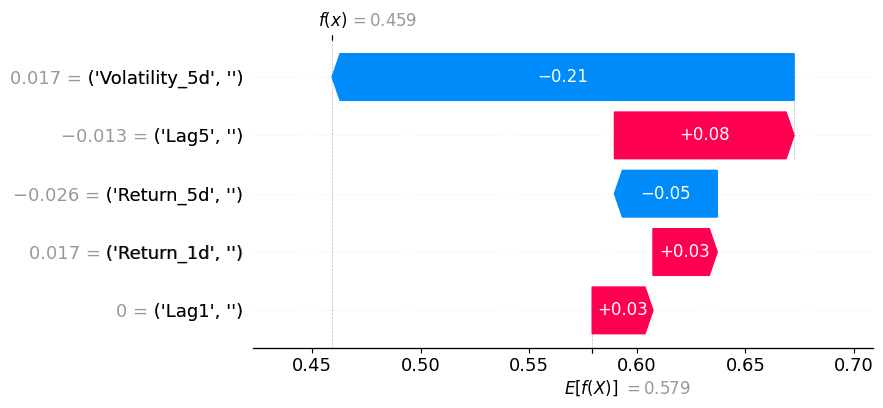

<Figure size 640x480 with 0 Axes>

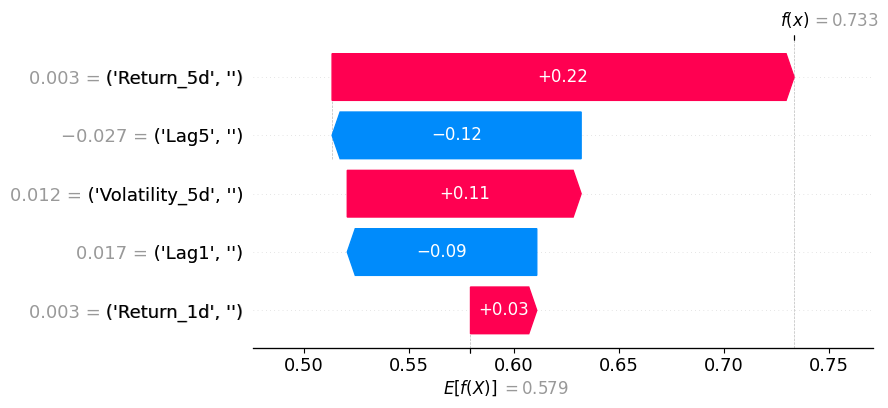

<Figure size 640x480 with 0 Axes>

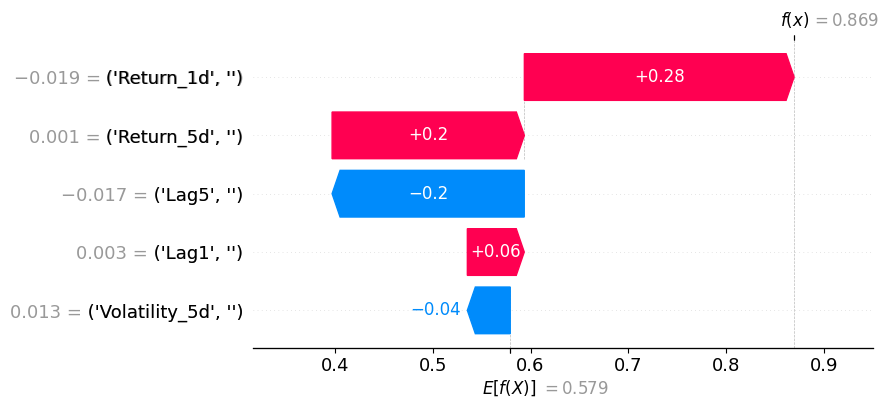

<Figure size 640x480 with 0 Axes>

In [17]:
#LOCAL SHAP (10 INSTANCES)
# Ensure we get correct values for waterfall
shap_values_array = shap_values.values  # SHAP values only
base_values = shap_values.base_values   # base values
feature_names = X_test.columns

local_indices = list(range(10))

for i in local_indices:
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_array[i],
            base_values=base_values[i],
            data=X_test.iloc[i],
            feature_names=feature_names
        )
    )
    plt.savefig(f"shap_local_{i}.png", dpi=300)
    plt.show()


In [18]:
#Neural Network Model
from tensorflow import keras
from tensorflow.keras import layers

# Build simple NN model
nn_model = keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile
nn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train NN
history = nn_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6263 - loss: 0.6772 - val_accuracy: 0.5945 - val_loss: 0.6778
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5957 - loss: 0.6827 - val_accuracy: 0.5920 - val_loss: 0.6766
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5853 - loss: 0.6818 - val_accuracy: 0.5970 - val_loss: 0.6765
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6076 - loss: 0.6731 - val_accuracy: 0.5970 - val_loss: 0.6763
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5816 - loss: 0.6826 - val_accuracy: 0.6045 - val_loss: 0.6764
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6056 - loss: 0.6659 - val_accuracy: 0.6045 - val_loss: 0.6767
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6030 - loss: 0.6688 - val_accuracy: 0.6045 - val_loss: 0.6761
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6138 - loss: 0.6616 - val_accuracy: 0.6020 - val_l

In [19]:
#LIME Local Explanation (10 Samples)
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Wrapper for LIME compatibility
def nn_predict(x):
    preds = nn_model.predict(x)
    return np.hstack((1 - preds, preds))   # Return two-class probs

# LIME Explainer
explainer_lime = LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=features,
    mode="classification"
)

local_indices = list(range(10))  # Same first 10 samples

for i in local_indices:
    exp = explainer_lime.explain_instance(
        X_test_scaled[i],
        nn_predict,
        num_features=5
    )
    exp.save_to_file(f"lime_local_{i}.html")   # Save for GitHub


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
#Save All Project Files for GitHub
df.to_csv("processed_financial_dataset.csv")
X_test.to_csv("X_test_data.csv")
y_test.to_csv("y_test_data.csv")

print("All important project files saved.")


All important project files saved.
